In [1]:
import numpy as np
import pandas as pd

In [2]:
rating_df = pd.read_csv('/content/drive/MyDrive/Dataset/data/animelist.csv',
                        usecols=["user_id", "anime_id", "rating"]
                        )
rating_df.head(4)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0


In [3]:
# User should rate atleast 400 animies
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 600].index)].copy()
len(rating_df)

50624747

In [4]:
# Scaling BTW (0 , 1.0)
#min_rating = min(rating_df['rating'])
#max_rating = max(rating_df['rating'])
#rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

#AvgRating = np.mean(rating_df['rating'])
#print('Avg', AvgRating)

In [5]:
# Removing Duplicated Rows
#duplicates = rating_df.duplicated()

#if duplicates.sum() > 0:
#    print('> {} duplicates'.format(duplicates.sum()))
#    rating_df = rating_df[~duplicates]

#print('> {} duplicates'.format(rating_df.duplicated().sum()))

In [6]:
#g = rating_df.groupby('user_id')['rating'].count()
#top_users = g.dropna().sort_values(ascending=False)[:20]
#top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')

#g = rating_df.groupby('anime_id')['rating'].count()
#top_animes = g.dropna().sort_values(ascending=False)[:20]
#top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')

#pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)

Data Preprocessing

In [7]:
# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 49011, Num of animes: 17560
Min rating: 0, Max rating: 10


In [9]:
# Shuffle
rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

In [10]:
# Split
test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 50614747
> Test set ratings: 10000


In [11]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

Model Building

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [20]:
# Embedding layers
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def RecommenderNet():
    embedding_size = 128

    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users,
                       output_dim = embedding_size)(user)

    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes,
                       output_dim = embedding_size)(anime)

    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')

    return model

model = RecommenderNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 anime (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 128)               6273408   ['user[0][0]']                
                                                                                                  
 anime_embedding (Embedding  (None, 1, 128)               2247680   ['anime[0][0]']               
 )                                                                                            

In [21]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
      return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss',
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,
]

In [22]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
5062/5062 [==============================] - 98s 17ms/step - loss: 0.7046 - mae: 3.8891 - mse: 26.3785 - val_loss: 0.6815 - val_mae: 3.8535 - val_mse: 26.0441 - lr: 1.0000e-05
Epoch 2/20
5062/5062 [==============================] - 52s 10ms/step - loss: 0.3761 - mae: 3.8836 - mse: 26.2379 - val_loss: 0.2343 - val_mae: 3.8452 - val_mse: 25.8505 - lr: 1.8000e-05
Epoch 3/20
5062/5062 [==============================] - 49s 10ms/step - loss: -0.9285 - mae: 3.8308 - mse: 25.6957 - val_loss: -1.9023 - val_mae: 3.7488 - val_mse: 24.9743 - lr: 2.6000e-05
Epoch 4/20
5062/5062 [==============================] - 51s 10ms/step - loss: -2.8765 - mae: 3.7529 - mse: 24.9440 - val_loss: -3.3670 - val_mae: 3.7017 - val_mse: 24.4561 - lr: 3.4000e-05
Epoch 5/20
5062/5062 [==============================] - 48s 10ms/step - loss: -4.3083 - mae: 3.7170 - mse: 24.5061 - val_loss: -4.7337 - val_mae: 3.6727 - val_mse: 24.0802 - lr: 4.2000e-05
Epoch 6/20
5062/5062 [==============================] - 50s

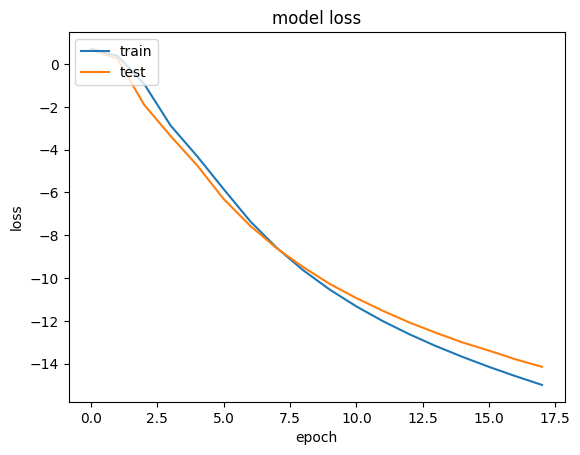

In [23]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Extracting weights from model

In [24]:
#truy xuất và chuẩn hóa trọng số cho các lớp 'anime_embedding' và 'user_embedding'
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [25]:
model.save('anime_model.h5')

from IPython.display import FileLink
FileLink(r'./anime_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/content/anime_model.h5

anime meta data

In [26]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/data/anime.csv')
df = df.replace("Unknown", np.nan)

In [27]:
# Fixing Names
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')

    return name

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df.sort_values(by=['Score'],
               inplace=True,
               ascending=False,
               kind='quicksort',
               na_position='last')

df = df[["anime_id", "eng_version",
         "Score", "Genres", "Episodes",
         "Type", "Premiered", "Members"]]

In [28]:
def getAnimeFrame(anime):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

sypnopsis data

In [29]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
sypnopsis_df = pd.read_csv('/content/drive/MyDrive/Dataset/data/anime_with_synopsis.csv', usecols=cols)

def getSypnopsis(anime):
    if isinstance(anime, int):
        return sypnopsis_df[sypnopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return sypnopsis_df[sypnopsis_df.Name == anime].sypnopsis.values[0]

Task 1: Finding Similar Animes (Item Based Recommendation)

In [30]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest

        rindex = df

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            sypnopsis = getSypnopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity,"genre": genre,
                                  'sypnopsis': sypnopsis})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

these animes are my fav

In [31]:
find_similar_animes('Dragon Ball Z', n=5, neg=False)

animes closest to Dragon Ball Z


,name,similarity,genre,sypnopsis
4,Dragon Ball,0.957021,"Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Gokuu Son is a young boy who lives in the woods all alone—that is, until a girl named Bulma runs into him in her search for a set of magical objects called the ""Dragon Balls."" Since the artifacts are said to grant one wish to whoever collects all seven, Bulma hopes to gather them and wish for a perfect boyfriend. Gokuu happens to be in possession of a dragon ball, but unfortunately for Bulma, he refuses to part ways with it, so she makes him a deal: he can tag along on her journey if he lets her borrow the dragon ball's power. With that, the two set off on the journey of a lifetime. They don't go on the journey alone. On the way, they meet the old Muten-Roshi and wannabe disciple Kuririn, with whom Gokuu trains to become a stronger martial artist for the upcoming World Martial Arts Tournament. However, it's not all fun and games; the ability to make any wish come true is a powerful one, and there are others who would do much worse than just wishing for a boyfriend. To stop those who would try to abuse the legendary power, they train to become stronger fighters, using their newfound strength to help the people around them along the way."
3,Dragon Ball GT,0.844970,"Action, Sci-Fi, Adventure, Comedy, Super Power, Magic, Fantasy, Shounen","Emperor Pilaf finally has his hands on the Black Star Dragon Balls after years of searching, which are said to be twice as powerful as Earth's normal ones. Pilaf is about to make his wish for world domination when he is interrupted by Gokuu Son. As a result, Pilaf flubs his wish and accidentally turns Gokuu back into a child. After the wish is granted, the Black Star Dragon Balls scatter across the galaxy. However, Gokuu discovers that they will cause the Earth to explode unless they are all brought back within a year. Uniting with his granddaughter Pan and a young adult Trunks, Gokuu sets off on an adventure through the universe to find the Black Star Dragon Balls and save his planet from destruction."
2,Dragon Ball Z Kai,0.747982,"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Five years after the events of Dragon Ball, martial arts expert Gokuu is now a grown man married to his wife Chi-Chi, with a four-year old son named Gohan. While attending a reunion on Turtle Island with his old friends Master Roshi, Krillin, Bulma and others, the festivities are interrupted when a humanoid alien named Raditz not only reveals the truth behind Gokuu's past, but kidnaps Gohan as well. With Raditz displaying power beyond anything Gokuu has seen before, he is forced to team up with his old nemesis, Piccolo, in order to rescue his son. But when Gokuu and Piccolo reveal the secret of the seven mystical wish-granting Dragon Balls to Raditz, he informs the duo that there is more of his race, the Saiyans, and they won’t pass up an opportunity to seize the power of the Dragon Balls for themselves. These events begin the saga of Dragon Ball Kai , a story that finds Gokuu and his friends and family constantly defending the galaxy from increasingly more powerful threats. Bizarre, comical, heartwarming and threatening characters come together in a series of battles that push the powers and abilities of Gokuu and his friends beyond anything they have ever experienced."
1,Dragon Ball Z:Broly – The Legendary Super Saiyan,0.746857,"Action, Adventure, Comedy, Fantasy, Sci-Fi, Shounen","s Goku investigates the destruction of the Southern Galaxy, Vegeta is taken to be King of the New Planet Vegeta, and to destroy the Legendary Super Saiyan, Broly. (Source: ANN)"
0,Dragon Ball Z Special 2:The History of Trunks,0.746376,"Adventure, Drama, Fantasy, Shounen",It has been thirteen years since the Androids began their killing rampage and Son Gohan is the only person fighting back. He takes Bulma's son Trunks as a student and even gives his own life to save Trunks's. Now Trunks must fi

In [32]:
find_similar_animes('Your Name.', n=5, neg=False)

animes closest to Your Name.


,name,similarity,genre,sypnopsis
4,A Silent Voice,0.955487,"Drama, School, Shounen","s a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye. Now in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends. Koe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
3,Your Lie in April,0.728385,"Drama, Music, Romance, School, Shounen","usic accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. Two years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori Miyazono, who stirs up his world and sets him on a journey to face music again. Based on the manga series of the same name, Shigatsu wa Kimi no Uso approaches the story of Kousei's recovery as he discovers that music is more than playing each note perfectly, and a single melody can bring in the fresh spring air of April."
2,Attack on Titan,0.724983,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
1,ERASED,0.707078,"Mystery, Psychological, Supernatural, Seinen","hen tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives. However, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right. Boku dake ga Inai Machi follows Satoru in his mission to uncover what truly tran

In [33]:
find_similar_animes('Sword Art Online', n=5, neg=False)

animes closest to Sword Art Online


,name,similarity,genre,sypnopsis
4,Sword Art Online II,0.857804,"Action, Game, Adventure, Romance, Fantasy","ar after escaping Sword Art Online, Kazuto Kirigaya has been settling back into the real world. However, his peace is short-lived as a new incident occurs in a game called Gun Gale Online, where a player by the name of Death Gun appears to be killing people in the real world by shooting them in-game. Approached by officials to assist in investigating the murders, Kazuto assumes his persona of Kirito once again and logs into Gun Gale Online, intent on stopping the killer. Once inside, Kirito meets Sinon, a highly skilled sniper afflicted by a traumatic past. She is soon dragged in his chase after Death Gun, and together they enter the Bullet of Bullets, a tournament where their target is sure to appear. Uncertain of Death Gun's real powers, Kirito and Sinon race to stop him before he has the chance to claim another life. Not everything goes smoothly, however, as scars from the past impede their progress. In a high-stakes game where the next victim could easily be one of them, Kirito puts his life on the line in the virtual world once more."
3,"No Game, No Life",0.832513,"Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mysterious god welcomes Sora and Shiro to Disboard, a world where all forms of conflict—from petty squabbles to the fate of whole countries—are settled not through war, but by way of high-stake games. This system works thanks to a fundamental rule wherein each party must wager something they deem to be of equal value to the other party's wager. In this strange land where the very idea of humanity is reduced to child's play, the indifferent genius gamer duo of Sora and Shiro have finally found a real reason to keep playing games: to unite the sixteen races of Disboard, defeat Tet, and become the gods of this new, gaming-is-everything world."
2,Attack on Titan,0.762989,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
1,Angel Beats!,0.732874,"Action, Comedy, Drama, School, Supernatural","Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Una

In [34]:
find_similar_animes('Black Clover', n=5, neg=False)

animes closest to Black Clover


,name,similarity,genre,sypnopsis
4,Boruto:Naruto Next Generations,0.761083,"Action, Adventure, Super Power, Martial Arts, Shounen","Following the successful end of the Fourth Shinobi World War, Konohagakure has been enjoying a period of peace, prosperity, and extraordinary technological advancement. This is all due to the efforts of the Allied Shinobi Forces and the village's Seventh Hokage, Naruto Uzumaki. Now resembling a modern metropolis, Konohagakure has changed, particularly the life of a shinobi. Under the watchful eye of Naruto and his old comrades, a new generation of shinobi has stepped up to learn the ways of the ninja. Boruto Uzumaki is often the center of attention as the son of the Seventh Hokage. Despite having inherited Naruto's boisterous and stubborn demeanor, Boruto is considered a prodigy and is able to unleash his potential with the help of supportive friends and family. Unfortunately, this has only worsened his arrogance and his desire to surpass Naruto which, along with his father's busy lifestyle, has strained their relationship. However, a sinister force brewing within the village may threaten Boruto's carefree life. New friends and familiar faces join Boruto as a new story begins in Boruto: Naruto Next Generations ."
3,Jujutsu Kaisen (TV),0.710166,"Action, Demons, Supernatural, School, Shounen","Idly indulging in baseless paranormal activities with the Occult Club, high schooler Yuuji Itadori spends his days at either the clubroom or the hospital, where he visits his bedridden grandfather. However, this leisurely lifestyle soon takes a turn for the strange when he unknowingly encounters a cursed item. Triggering a chain of supernatural occurrences, Yuuji finds himself suddenly thrust into the world of Curses—dreadful beings formed from human malice and negativity—after swallowing the said item, revealed to be a finger belonging to the demon Sukuna Ryoumen, the ""King of Curses."" Yuuji experiences first-hand the threat these Curses pose to society as he discovers his own newfound powers. Introduced to the Tokyo Metropolitan Jujutsu Technical High School, he begins to walk down a path from which he cannot return—the path of a Jujutsu sorcerer."
2,Dragon Quest: Dai no Daibouken (2020),0.628831,"Action, Adventure, Fantasy, Shounen","long time ago, there was a valiant swordsman who came to be known simply as ""the hero."" There was a demon who has caused people suffering. The hero and his companions arrived to challenge the demon to a battle and by combining their powers, the battle was brought swift conclusion. With no one around to cause trouble, the island became a quiet place where everyone could live together in peace. Several years later, the demon is revived. Our present-day protagonist, Dai, lives on a remote island in the southern seas and dreams of becoming a great hero. When he hears about the demon's revival, Dai and his friends take it upon themselves to stop him and the evil force that revived him. Along the way, Dai discovers the identity of ""the hero,"" the truth behind the evil force who revived the demon, and Dai's own hidden powers that surface in times of peril. (Source: MU, edited)"
1,Attack on Titan Final Season,0.622051,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as 

In [38]:
find_similar_animes('Death Note', n=5, neg=False)

animes closest to Death Note


,name,similarity,genre,sypnopsis
4,Attack on Titan,0.870740,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
3,Fullmetal Alchemist:Brotherhood,0.828699,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
2,Code Geass:Lelouch of the Rebellion R2,0.817584,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
1,Code Geass:Lelouch of the Rebellion,0.812630,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with 

Task 2: Finding Similar Users (User Based Recommendation)

In [39]:
print('> picking up random user')

ratings_per_user = rating_df.groupby('user_id').size()
random_user = ratings_per_user[ratings_per_user < 700].sample(1, random_state=None).index[0]
print('> user_id:', random_user)

> picking up random user
> user_id: 43000


In [40]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest

        rindex = df
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id,
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity",
                                                        ascending=False)

        return Frame

    except:
        print('{}!, Not Found in User list'.format(name))


In [41]:
similar_users = find_similar_users(int(random_user),
                                   n=5,
                                   neg=False)

similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users.head(5)

> users similar to #43000


,similar_users,similarity
4,261037,0.501127
3,164813,0.493083
2,50414,0.441943
1,37986,0.441504
0,338647,0.439645


User preferences

In [43]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400,
                             background_color='white',
                             colormap='gnuplot').generate_from_frequencies(all_genres)

    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)

        genres_list = []
        for genres in frame['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1
        if plot:
            showWordCloud(all_genres)

        return genres_list


def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)#.head(10)
        .anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))

        print('> preferred genres')

    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows#.eng_version.values

> User #43000 has rated 347 movies (avg. rating = 7.6)
> preferred genres


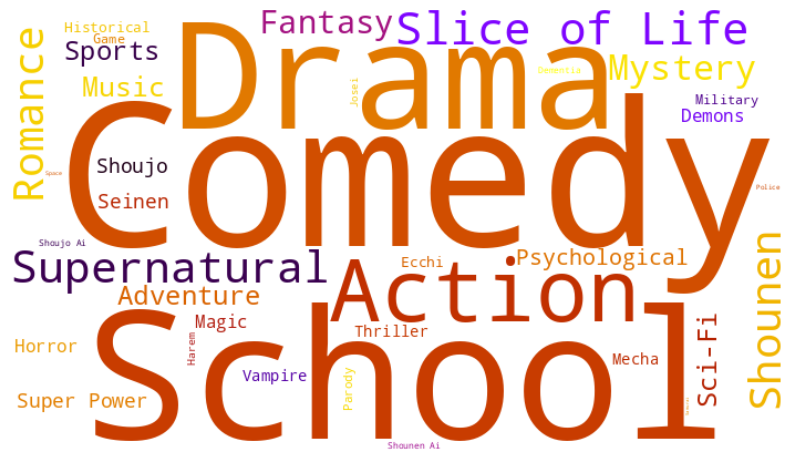

> animes highly rated by this user


,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
14963,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
9886,A Silent Voice,"Drama, School, Shounen"


In [44]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(5)

Task 3: Recommending animes for a user

In [45]:
def get_recommended_animes(similar_users, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), verbose=0)
        pref_list = pref_list[~ pref_list.eng_version.isin(user_pref.eng_version.values)]
        anime_list.append(pref_list.eng_version.values)

    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

    for i, anime_name in enumerate(sorted_list.index):
        n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
        if isinstance(anime_name, str):
            try:
                frame = getAnimeFrame(anime_name)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                sypnopsis = getSypnopsis(int(anime_id))
                recommended_animes.append({#"anime_id": anime_id ,
                                           "n": n_user_pref,
                                            "anime_name": anime_name,
                                            "Genres": genre,
                                            "sypnopsis": sypnopsis})
            except:
                pass

    return pd.DataFrame(recommended_animes)

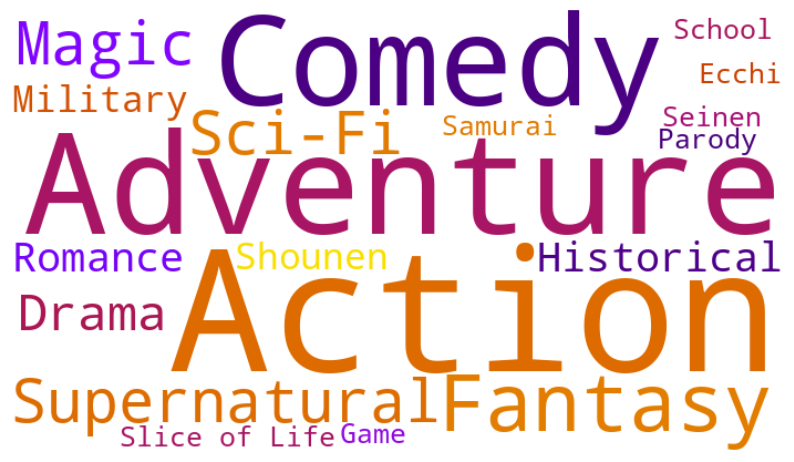


> Top recommendations for user: 43000


,n,anime_name,Genres,sypnopsis
0,5,Vinland Saga,"Action, Adventure, Drama, Historical, Seinen","Young Thorfinn grew up listening to the stories of old sailors that had traveled the ocean and reached the place of legend, Vinland. It's said to be warm and fertile, a place where there would be no need for fighting—not at all like the frozen village in Iceland where he was born, and certainly not like his current life as a mercenary. War is his home now. Though his father once told him, ""You have no enemies, nobody does. There is nobody who it's okay to hurt,"" as he grew, Thorfinn knew that nothing was further from the truth. The war between England and the Danes grows worse with each passing year. Death has become commonplace, and the viking mercenaries are loving every moment of it. Allying with either side will cause a massive swing in the balance of power, and the vikings are happy to make names for themselves and take any spoils they earn along the way. Among the chaos, Thorfinn must take his revenge and kill Askeladd, the man who murdered his father. The only paradise for the vikings, it seems, is the era of war and death that rages on."
1,4,Golden Time,"Comedy, Drama, Romance","Due to a tragic accident, Banri Tada is struck with amnesia, dissolving the memories of his hometown and past. However, after befriending Mitsuo Yanagisawa, he decides to move on and begin a new life at law school in Tokyo. But just as he is beginning to adjust to his college life, the beautiful Kouko Kaga dramatically barges into Banri's life, and their chance meeting marks the beginning of an unforgettable year. After having a glimpse of college life, Banri learns that he is in a new place and a new world—a place where he can be reborn, to have new friends, fall in love, makes mistakes and grow. And as he begins to discover who he was, the path he has chosen leads him towards a blindingly bright life that he will never want to forget."
2,4,GATE,"Action, Military, Adventure, Fantasy","Several months have passed since the infamous Ginza Incident, with tensions between the Empire and JSDF escalating in the vast and mysterious ""Special Region"" over peace negotiations. The greed and curiosity of the global powers have also begun to grow, as reports about the technological limitations of the magical realm's archaic civilizations come to light. Meanwhile, Lieutenant Youji Itami and his merry band of female admirers struggle to navigate the complex political intrigue that plagues the Empire's court. Despite her best efforts, Princess Piña Co Lada faces difficulties attempting to convince her father that the JSDF has no intention of conquering their kingdom. Pressured from both sides of the Gate, Itami must consider even more drastic measures to fulfill his mission."
3,4,OreImo,"Slice of Life, Comedy","Kirino Kousaka embodies the ideal student with equally entrancing looks. Her grades are near perfect, and to cover her personal expenses, she works as a professional model alongside her best friend Ayase Aragaki, who abhors liars and all things otaku. But what Ayase doesn't know is that Kirino harbors a deep, entrenched secret that will soon be brought to light. At home one day, Kyousuke, Kirino's perfectly average brother, stumbles upon an erotic game that belongs to none other than his seemingly flawless little sister. With her reputation at stake, Kirino places a gag order on her sibling while simultaneously introducing him to the world of eroge and anime. Through Kirino, Kyousuke encounters the gothic lolita Ruri Gokou and the bespectacled otaku Saori Makishima, thus jump-starting an entirely new lifestyle. But as he becomes more and more involved in his little sister's secret life, it becomes that much harder to keep under wraps."
4,4,"No Game, No Life","Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username "

In [46]:
recommended_animes = get_recommended_animes(similar_users, n=10)
getFavGenre(recommended_animes, plot=True)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes

Ranking based Recommendation

In [47]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==random_user]
anime_not_watched_df = df[
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])

    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genres.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue
        Results.append({#"anime_id": id_,
                        "name": name,
                        "pred_rating": rating,
                        "genre": genre,
                        'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)


Results = pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)
Results

Showing recommendations for user: 43000
528/528 [==============================] - 1s 2ms/step
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


,name,pred_rating,genre,sypnopsis
8,Ace of Diamond:Second Season,0.999771,"Comedy, Sports, School, Shounen","fter the National Tournament, the Seidou High baseball team moves forward with uncertainty as the Fall season quickly approaches. In an attempt to build a stronger team centered around their new captain, fresh faces join the starting roster for the very first time. Previous losses weigh heavily on the minds of the veteran players as they continue their rigorous training, preparing for what will inevitably be their toughest season yet. Rivals both new and old stand in their path as Seidou once again climbs their way toward the top, one game at a time. Needed now more than ever before, Furuya and Eijun must be determined to pitch with all their skill and strength in order to lead their team to victory. And this time, one of these young pitchers may finally claim that coveted title: ""The Ace of Seidou."""
3,You and Me 2,0.999498,"Comedy, Drama, Romance, School, Shounen, Slice of Life","""No matter how many years go by, I'm sure we'll still be laughing together."" Twins Yuta and Yuki, Kaname, and Shun have been childhood friends since kindergarten. When transfer student Chizuru joins them, their five man school life becomes all the more lively. Through the changing seasons, the boys will find laughter, surprises, love, and new encounters waiting for them. The second season of the boys growing a little every day of their invaluable daily lives is about to begin! (Source: Crunchyroll)"
1,K-ON! The Movie,0.999440,"Music, Slice of Life, Comedy","Graduation looms for the founding members of the Light Music Club. With only a few precious weeks of school left, the girls decide to make the most of it and plan a trip abroad. Hawaii, New York, Dubai—many destinations are suggested, but after a little help from the club's precious pet turtle, Ton-chan, London is chosen as the host of their next misadventure! Yui Hirasawa, Mio Akiyama, Tsumugi Kotobuki, Ritsu Tainaka, and Azusa Nakano will visit famous landmarks, perform live music for Londoners, and eat all sorts of delicious food, all while stumbling clumsily from place to place. But the fun won't last forever, as heartfelt songs and goodbyes will be made as their high school days together come to a close. One thing is for certain though: the undeniable friendships these girls have formed is something that will carry on long after the final scene rolls."
5,Medaka Box Abnormal,0.999407,"Action, Comedy, Ecchi, Martial Arts, School, Shounen, Super Power","fter the defeat of Myouri Unzen at the hands of Medaka Kurokami and her Student Council, peace has returned to Hakoniwa Academy—at least, for a short while. Soon, Medaka, Zenkichi Hitoyoshi, Kouki Akune, and Mogana Kikaijima find themselves wrapped up in another sinister scheme, known as the ""Flask Plan,"" led by the school's principal himself. However, the council's first problem is to deal with a whole new group of superhuman students calling themselves the ""Thirteen Party,"" led by the egotistical but powerful Oudo Miyakonojou. With the mysterious Flask Plan, Oudo's tyranny, and the resurfacing of an old enemy, the state of Hakoniwa Academy is far from tranquil, and Medaka and her companions have their hands full as things only get a lot more abnormal."
4,Phi-Brain ~ Puzzle of God:The Orpheus Order,0.999210,"Action, Game, Mystery, Shounen","The puzzles get tougher and even more deadly as Kaito Daimon continues his battle against the power hungry Givers of the POG. And with one team member already switching sides, will Kaito have what it takes to keep solving the deadly puzzle traps put before him and reach the fabled Puzzle of God? More importantly, will he be able to solve the puzzles AND maintain his sanity? (Source: Sentai Filmworks)"
6,Little Busters! ~Refrain~,0.999123,"Slice of Life, Comedy, Supernatural, Drama, Romance, School","Following the Little Busters after they lost their first baseball game, the team decides to hav

In [49]:
model.save('anime_model_.h5')

from IPython.display import FileLink
FileLink(r'./anime_model_.h5')

/content/anime_model_.h5